In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_50088/2365321851.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]
sns.set_theme(style="whitegrid")
no_indels = ("longshot")

In [46]:
frames = []
COV = 100
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    df = pd.read_csv(p, sep="\t")
    df["sample"] = p.parent.name
    if "without_repetitive_regions" in p.name:
        continue
    if "illumina" in str(p):
        df["caller"] = "illumina"
        df["depth"] = "illumina"
        df["mode"] = "simplex"
        df["version"] = "illumina"
        df["model"] = "illumina"
    else:
        df["caller"] = p.parts[-7]
        depth = int(p.parts[-6][:-1])
        if depth != COV:
            continue
        df["depth"] = p.parts[-6]
        df["mode"] = p.parts[-5]
        df["version"] = p.parts[-4]
        df["model"] = p.parts[-3].split("_")[-1].split("@")[0]
    frames.append(df)
    # duplicate Illumina as duplex also
    # if "illumina" in str(p):
    #     df2 = df.copy()
    #     df2["caller"] = "illumina"
    #     df2["depth"] = "illumina"
    #     df2["mode"] = "duplex"
    #     df2["version"] = "illumina"
    #     df2["model"] = "illumina"
    #     frames.append(df2)

In [66]:
pr_df = pd.concat(frames)
pr_df.reset_index(inplace=True, drop=True)

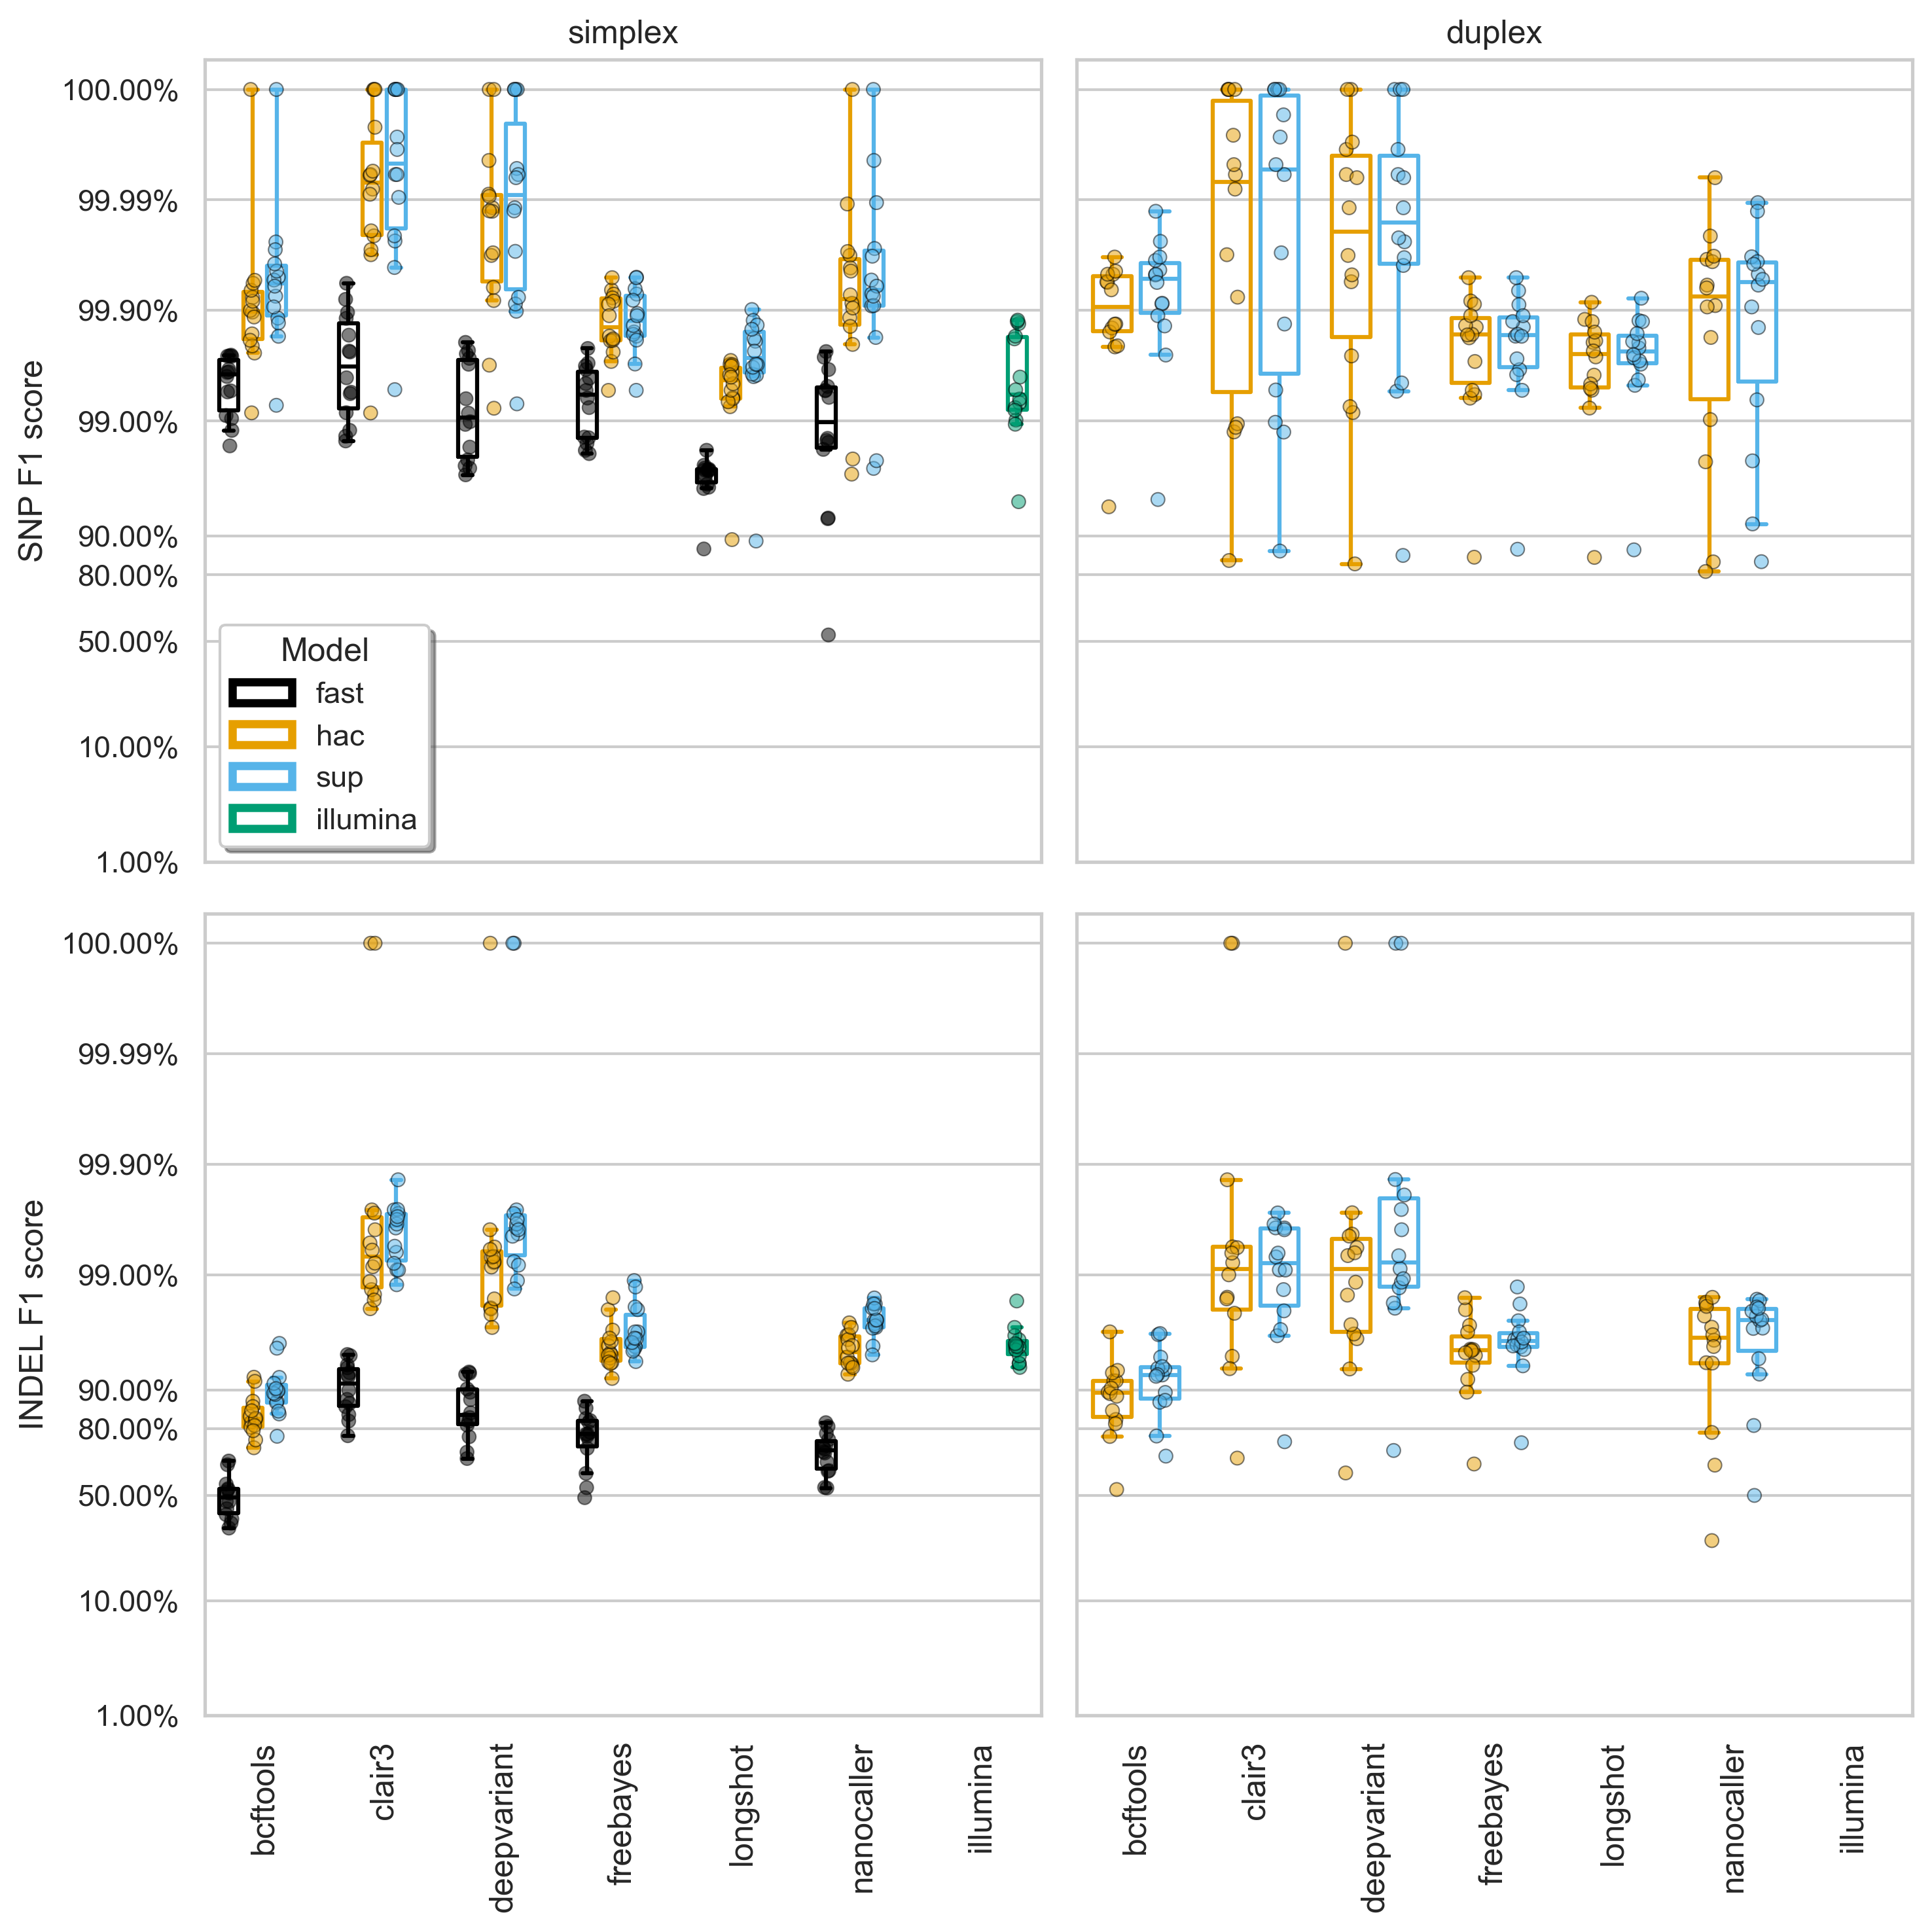

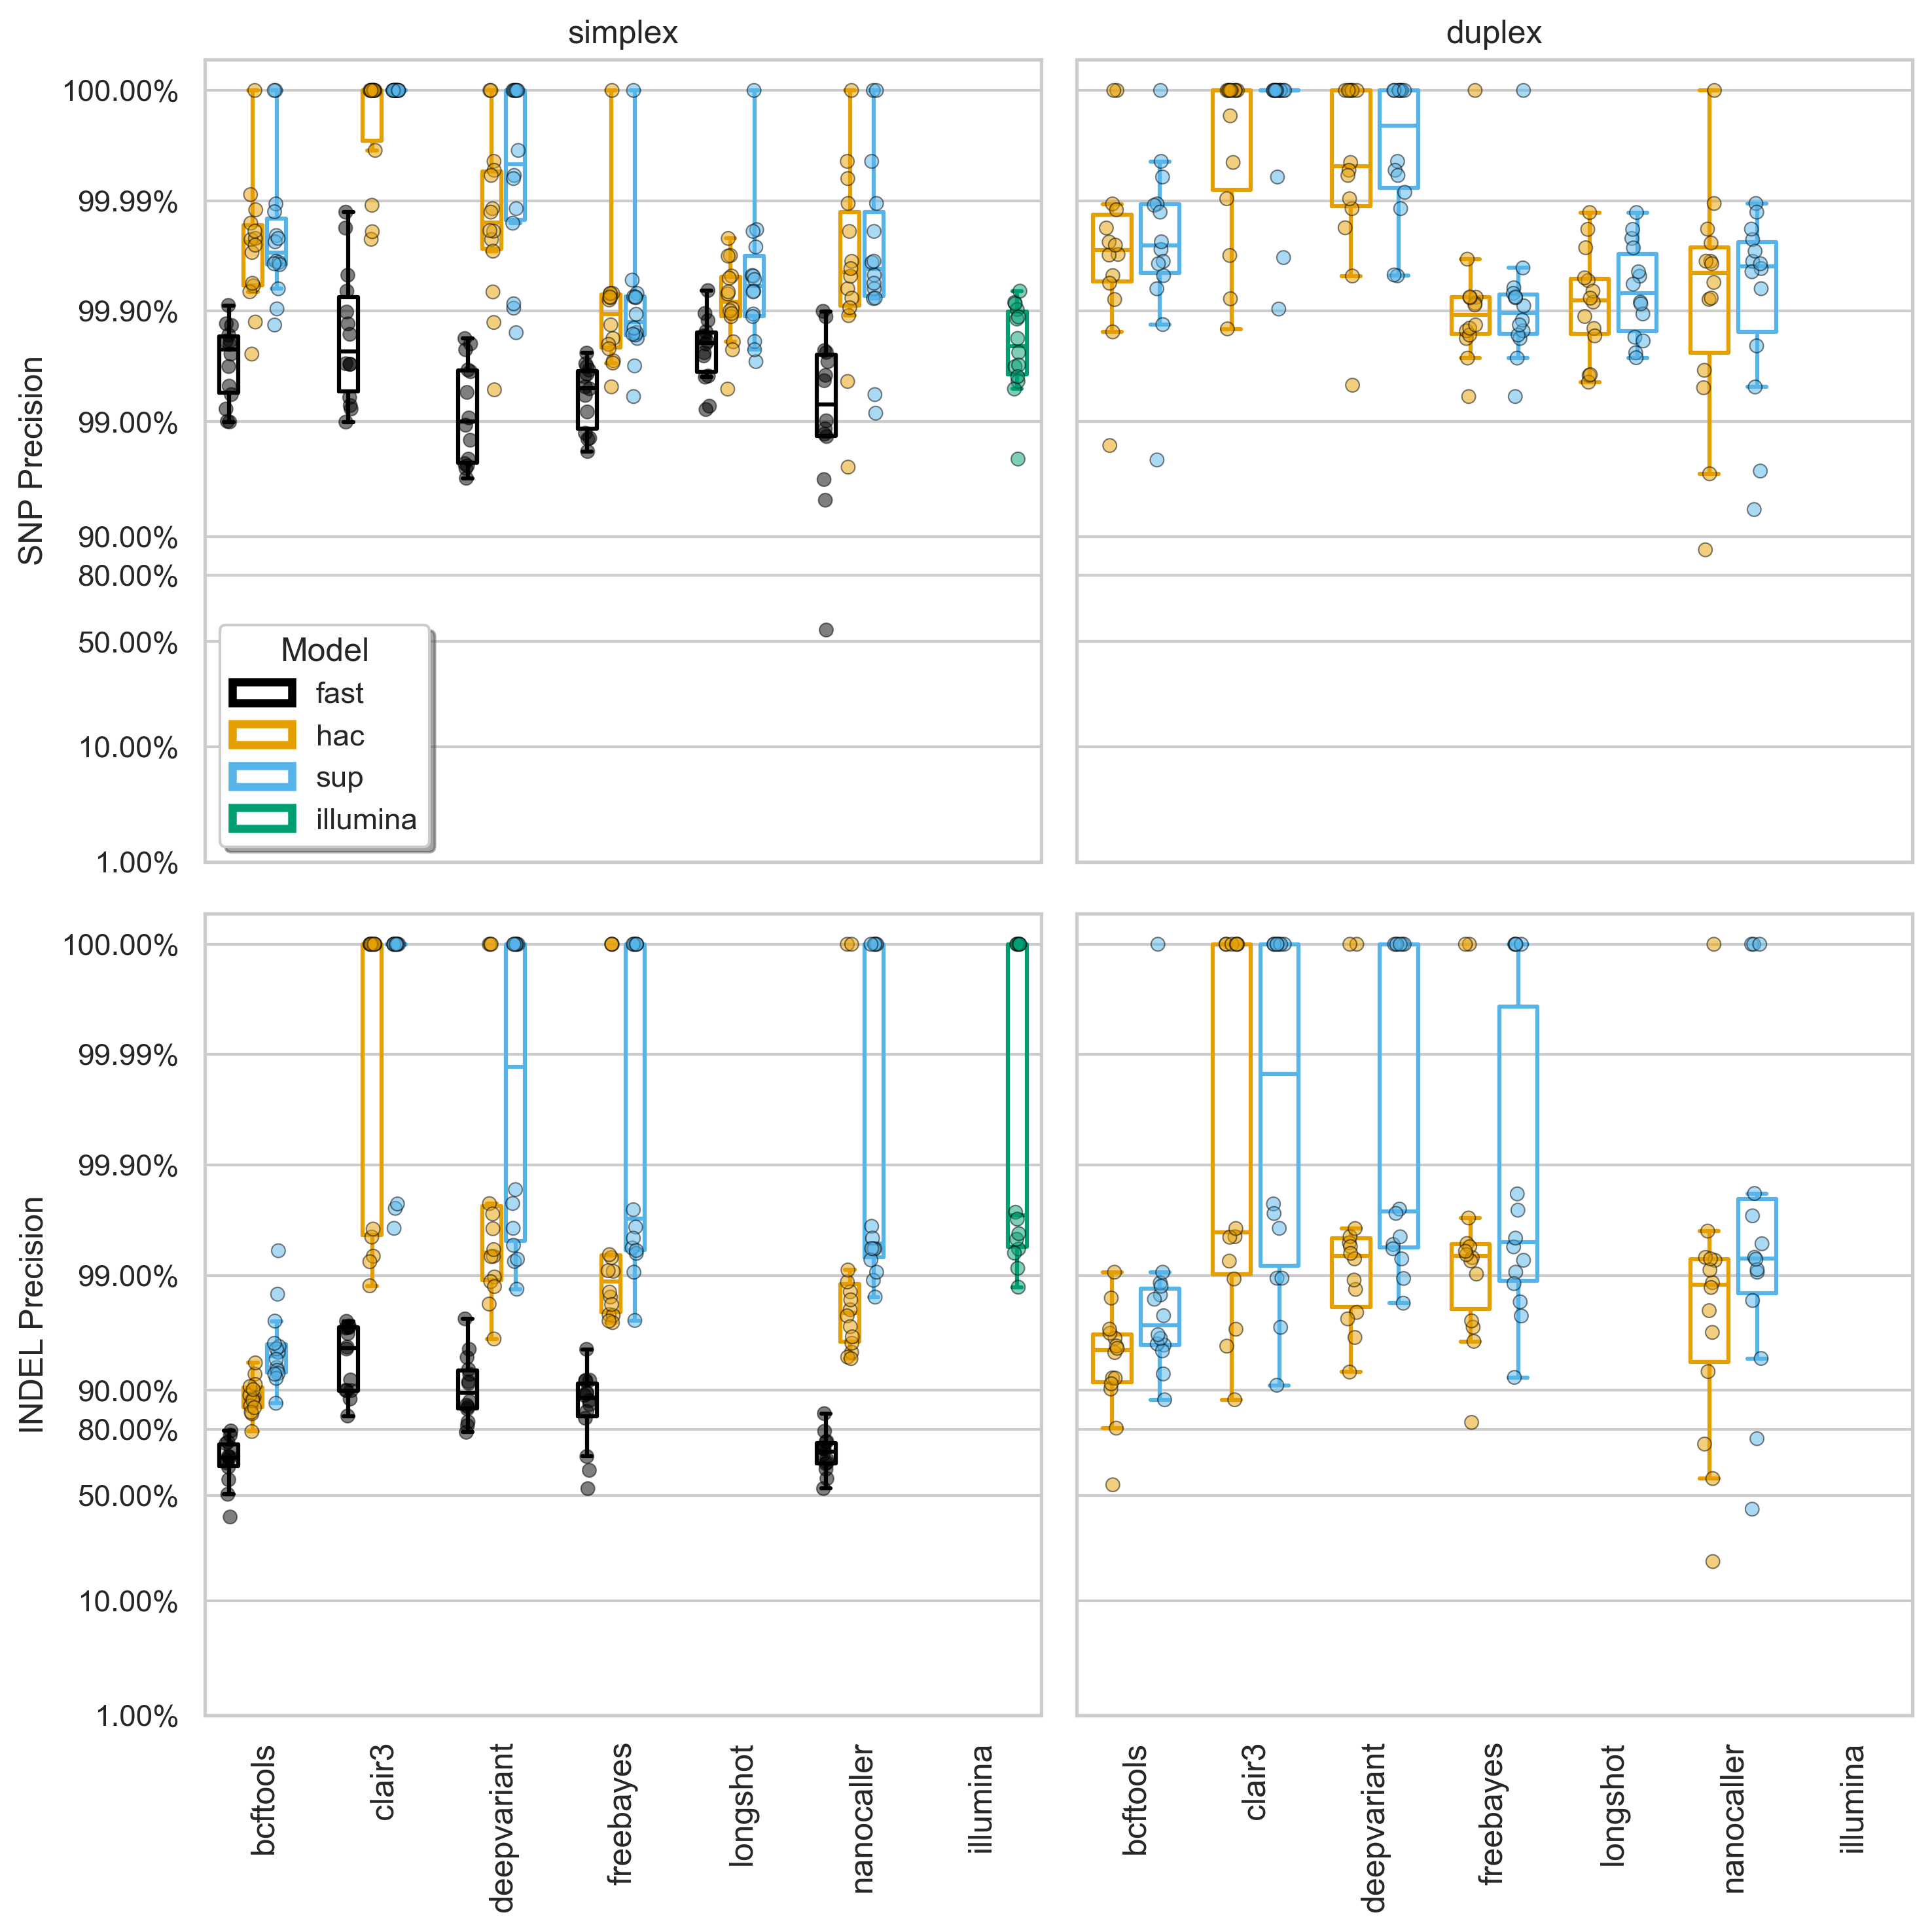

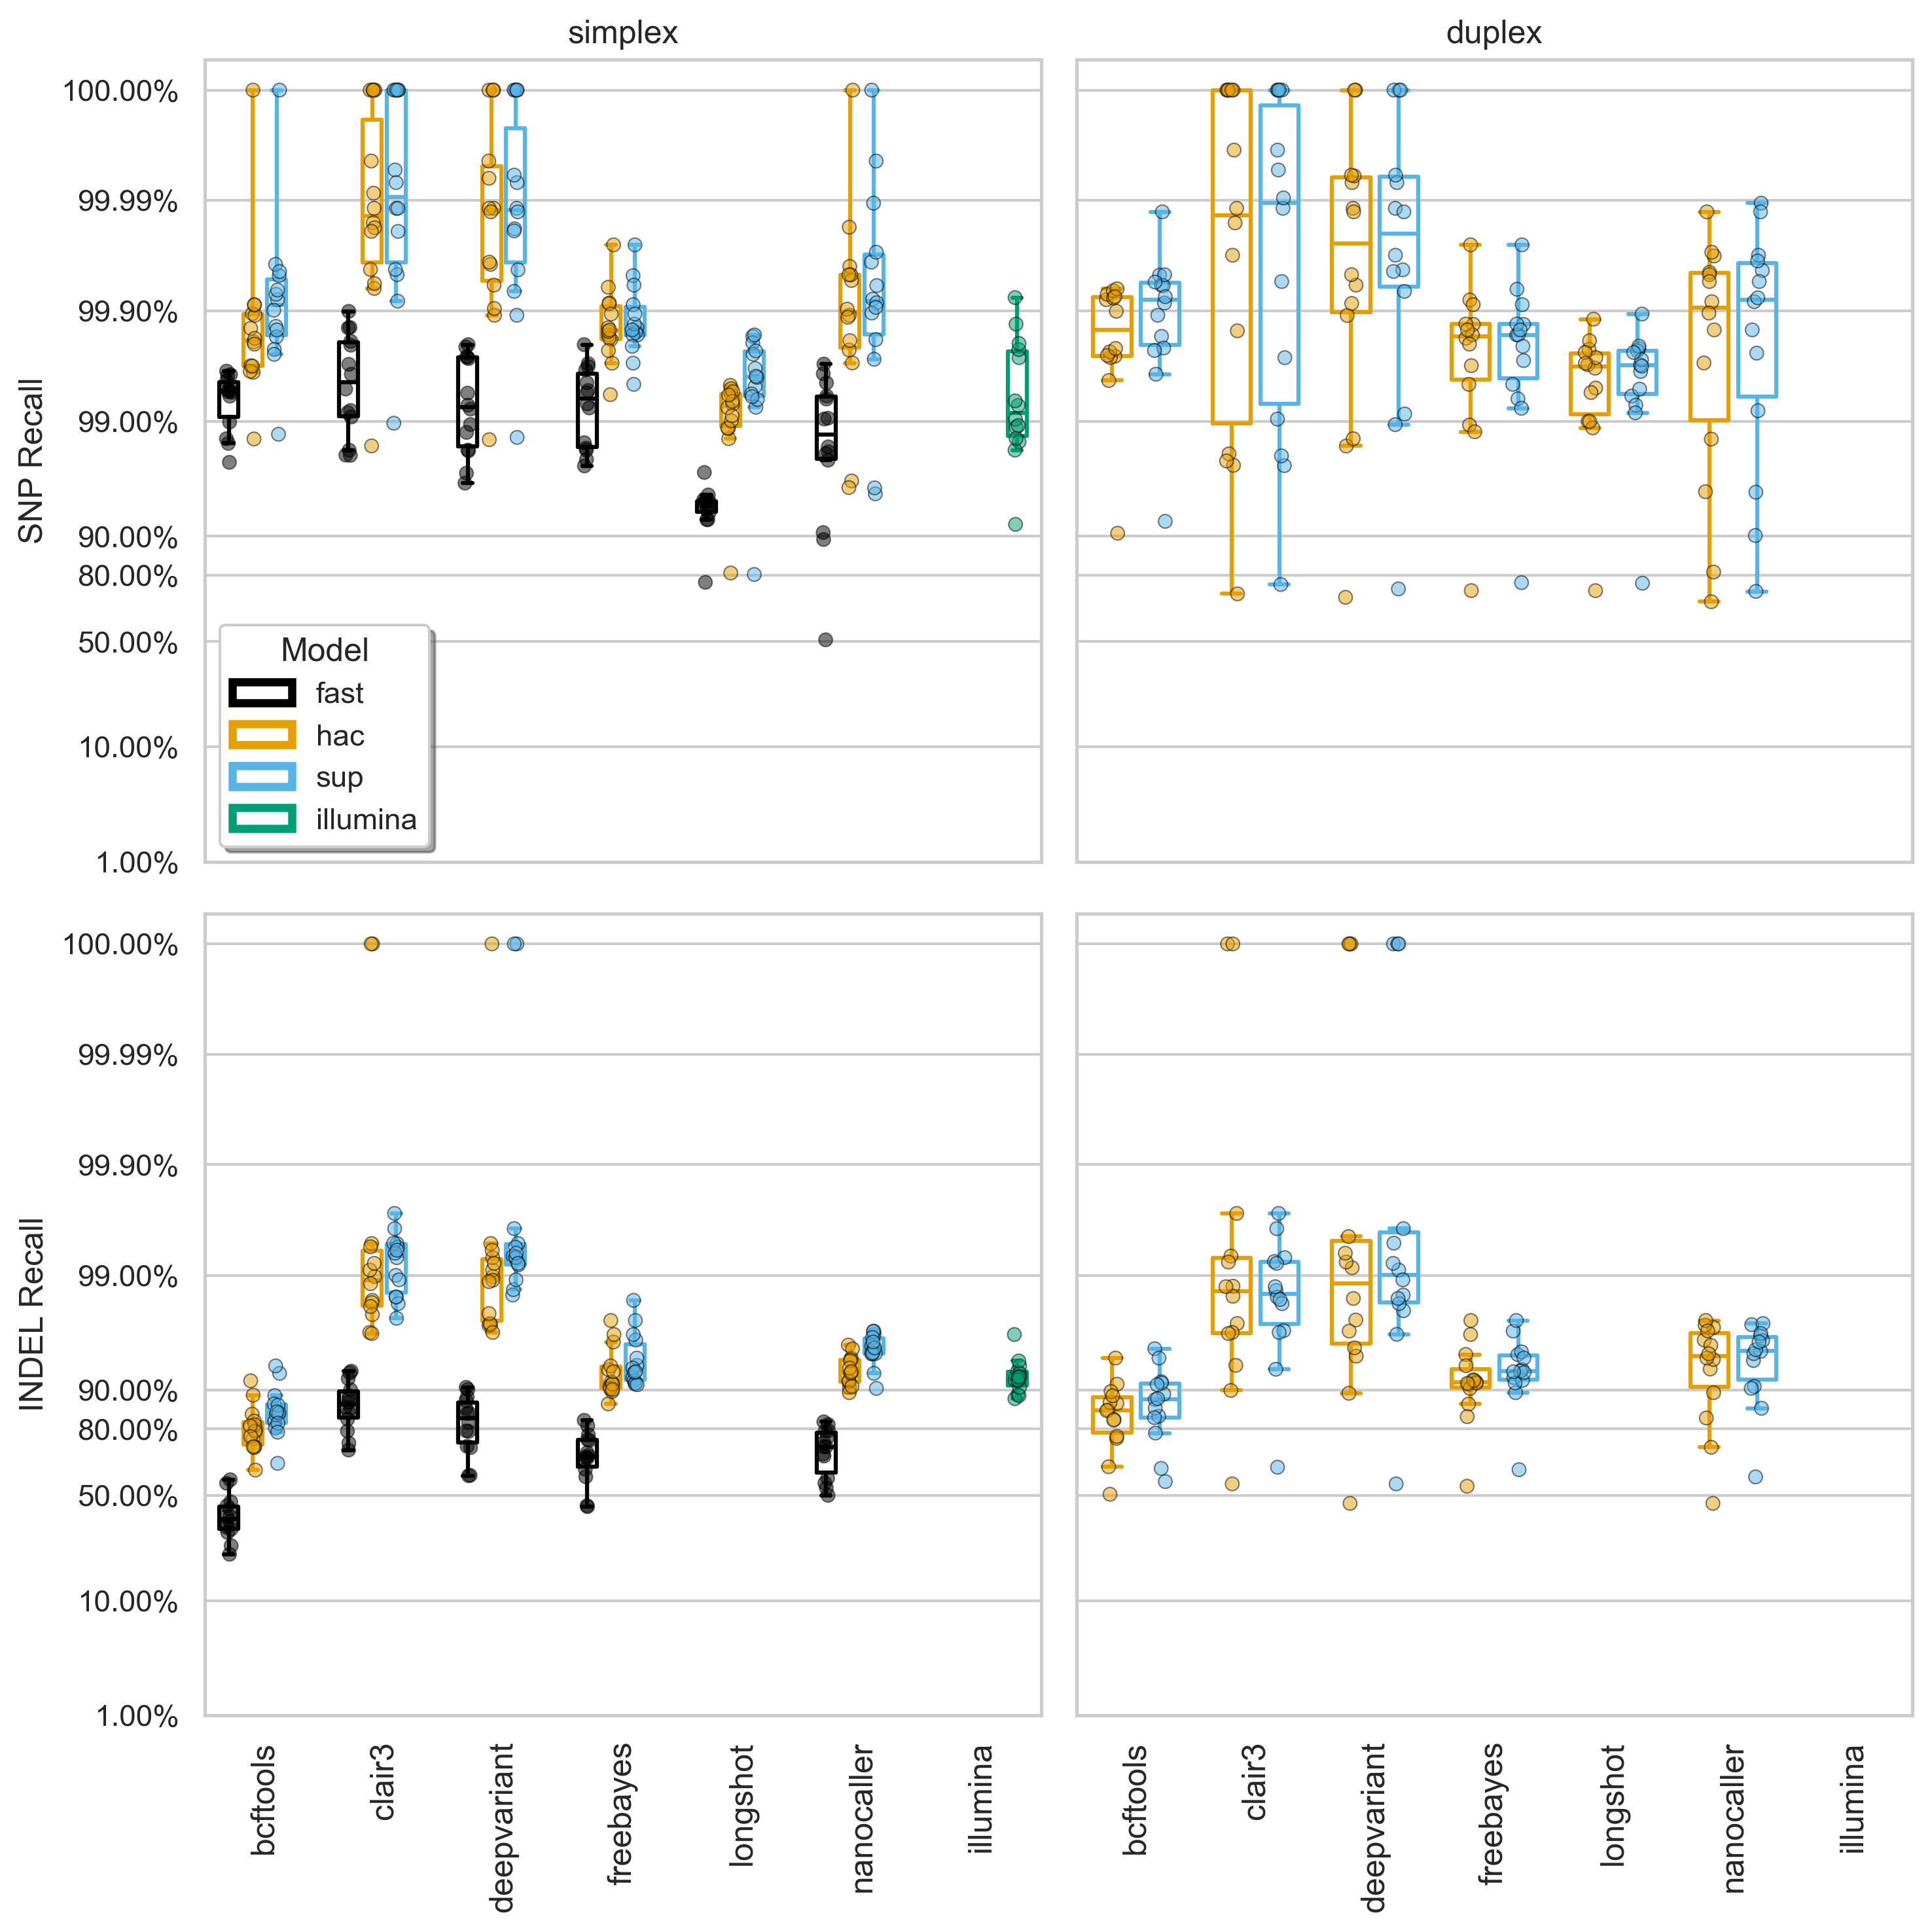

In [57]:
metrics = ["F1_SCORE", "PREC", "RECALL"]
x = "caller"
hue = "model"
cols = "mode"
ncols = pr_df[cols].nunique()
rows = ("SNP", "INDEL")
nrows = len(rows)
dataix = pr_df.groupby([x, hue, cols, "VAR_TYPE", "sample"])["F1_SCORE"].idxmax()
data = pr_df.iloc[dataix]
order = sorted(set(data[x]))
# move illumina to end
order.remove("illumina")
order.append("illumina")
hue_order = sorted(set(data[hue]))
# move illumina to end
hue_order.remove("illumina")
hue_order.append("illumina")
# map each caller in hue order to a colour in cud
pal = {c: cud()[i] for i, c in enumerate(hue_order)}

for y in metrics:
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(10, 10), dpi=300, sharex=True, sharey=True,
    )
    i = 0
    for vartype in rows:
        for mode in reversed(data[cols].unique()):
            legend = i == 0
            ax = axes.flatten()[i]
            # transform precision so logit shows values of 1.0 - i.e. change values of 1.0 to 0.99999
            df = data.query("VAR_TYPE == @vartype and mode == @mode")
            if mode == "duplex":
                df = df.query("model != 'fast'")
            if vartype == "INDEL":
                df = df.query("caller not in @no_indels")

            cap = 0.99999
            df.loc[:, y] = df[y].apply(lambda v: cap if v > cap else v)
            yticks = [0.01, 0.1, 0.5, 0.8, 0.9, 0.99, 0.999, 0.9999, cap]
            yticklabels = [f"{yval:.2%}" for yval in yticks]
            sns.boxplot(
                data=df,
                x=x,
                y=y,
                order=order,
                hue=hue,
                ax=ax,
                palette=pal,
                fill=False,
                fliersize=0,
                legend=legend,
                gap=0.2,
            )
            sns.stripplot(
                data=df,
                x=x,
                y=y,
                order=order,
                hue=hue,
                ax=ax,
                palette=pal,
                alpha=0.5,
                dodge=True,
                legend=False,
                linewidth=0.5,
                edgecolor="black",
            )

            ax.set_yscale("logit", nonpositive="clip")
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels)
            # make ylabels more readable
            ylabel = {
                "F1_SCORE": "F1 score",
                "PREC": "Precision",
                "RECALL": "Recall",
            }[y]
            ax.set_ylabel(f"{vartype} {ylabel}")
            # rotate the xlabels
            ax.tick_params(axis='x', labelrotation=90, labelsize=12)
            ax.set_xlabel("")

            if legend:
                handles, labels = ax.get_legend_handles_labels()

                for h in handles:
                    h.set_linewidth(3)

                ax.legend(
                    handles=handles,
                    labels=labels,
                    framealpha=1.0,
                    fancybox=True,
                    shadow=True,
                    title=hue.capitalize(),
                )

                legend = False

            
            # if (i + 1) % ncols == 0:
            #     ax2 = ax.twinx()
            #     ax2.grid(False)
            #     ax2.set_ylabel(vartype)
            #     ax2.set_yticks([])
            #     ax2.set_yticklabels([])
            #     ax.tick_params(axis='y', which='both',length=0)

            #     # get rid of all minor y-axis ticks
            #     ax.yaxis.set_minor_locator(plt.NullLocator())

            if i < ncols:
                ax.set_title(mode)

            i += 1

    fig.tight_layout()
    # leg_cols = len(data[hue].unique())
    # for h in handles:
    #     h.set_linewidth(3)
    # fig.legend(
    #     handles=handles,
    #     labels=labels,
    #     loc="upper center",
    #     bbox_to_anchor=(0.52, 0.61),
    #     ncol=leg_cols,
    #     framealpha=1.0,
    #     fancybox=True,
    #     shadow=True,
    #     title=hue.capitalize(),
    # )

In [69]:
dataix = pr_df.groupby([x, hue, cols, "VAR_TYPE", "sample"])["F1_SCORE"].idxmax()
data = pr_df.iloc[dataix]
data = data.query("VAR_TYPE not in ('ALL', 'SV') and not (mode == 'duplex' and model == 'fast')")
# make the mode and model columns the first and second columns
col = data.pop("model")
data.insert(0, col.name, col)
col = data.pop("mode")
data.insert(0, col.name, col)
col = data.pop("sample")
data.insert(0, col.name, col)
col = data.pop("caller")
data.insert(0, col.name, col)
data.sort_values(
    by=["mode", "model", "sample"], ascending=[False, True, True], inplace=True
)
data

,caller,sample,mode,model,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,depth,version
209336,bcftools,AJ292__202310,simplex,fast,INDEL,52,0.581395,0.259067,0.358423,1.927512,193,50,143,86,50,36,100x,v4.3.0
209075,bcftools,AJ292__202310,simplex,fast,SNP,27,0.997542,0.994530,0.996033,24.015783,22850,22725,125,22781,22725,56,100x,v4.3.0
130968,clair3,AJ292__202310,simplex,fast,INDEL,5,0.900000,0.792746,0.842975,8.040316,193,153,40,170,153,17,100x,v4.3.0
130855,clair3,AJ292__202310,simplex,fast,SNP,3,0.996965,0.992035,0.994494,22.591702,22850,22668,182,22737,22668,69,100x,v4.3.0
1092273,deepvariant,AJ292__202310,simplex,fast,INDEL,12,0.811429,0.735751,0.771739,6.415685,193,142,51,175,142,33,100x,v4.3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281896,freebayes,RDH275__202311,duplex,sup,SNP,0,0.999253,0.998508,0.998880,29.509550,5361,5353,8,5357,5353,4,100x,v4.3.0
247953,longshot,RDH275__202311,duplex,sup,INDEL,0,1.000000,0.000000,0.000000,0.000000,128,0,128,0,0,0,100x,v4.3.0
247533,longshot,RDH275__202311,duplex,sup,SNP,81,0.998132,0.996829,0.997480,25.986156,5361,5344,17,5354,5344,10,100x,v4.3.0
22485,nanocaller,RDH275__202311,duplex,sup,INDEL,0,1.000000,0.960938,0.980080,17.007044,128,123,5,123,123,0,100x,v4.3.0
